In [1]:
!pip install kaggle

In [0]:
from getpass import getpass
import os
user = 'ahmadelsallab'
key = '6b7ffe97ff5bc0656e325b746b72fa31'

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c ashrae-energy-prediction

  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 84.9MB/s]
 95% 114M/120M [00:03<00:00, 44.3MB/s] 
100% 120M/120M [00:03<00:00, 35.6MB/s]
 98% 164M/167M [00:02<00:00, 64.2MB/s]
100% 167M/167M [00:02<00:00, 63.8MB/s]
100% 88.4M/88.4M [00:01<00:00, 53.1MB/s]

  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 42.2MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 71.1MB/s]


In [4]:
!unzip train.csv.zip
!unzip weather_train.csv.zip
!unzip building_metadata.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
unzip:  cannot find or open building_metadata.csv.zip, building_metadata.csv.zip.zip or building_metadata.csv.zip.ZIP.


In [2]:
import pandas as pd
train = pd.read_csv('train.csv')
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [3]:
building_meta = pd.read_csv('building_metadata.csv')
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [4]:
weather_train = pd.read_csv('weather_train.csv')
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


No missing vals by merging the building_metadata, so no missing building_id

So the missing vals come either from missing timestamp, or missing site_id's

We need to have all entries, although if missing some data. So we should specify the merge method. 

If we use outer, we could get extra rows, since we might have extra foreign keys not referenced.

So we use left

In [5]:
#train_df1 = pd.merge(train, building_meta, on='building_id', how='outer')# outer: You could get longer merge, due to extra building id's for example
train_df1 = pd.merge(train, building_meta, on='building_id', how='left')
print(len(train_df1) - len(train))
#train_df = pd.merge(train_df1, weather_train, on=['timestamp','site_id'], how='outer')## outer: You could get longer merge, due to extra site_id's or timestamps for example
train_df = pd.merge(train_df1, weather_train, on=['timestamp','site_id'], how='left')
print(len(train_df) - len(train_df1))


0
0


In [0]:
del(train)
del(building_meta)
del(weather_train)

In [10]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [11]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


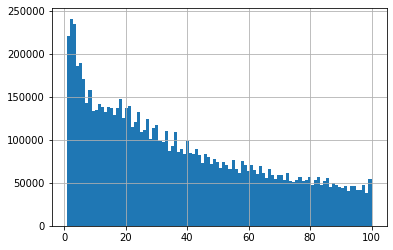

In [12]:
#train_df.meter_reading.hist(bins=100, range=[0,100])
train_df.meter_reading.hist(bins=100, range=[1,100])
# range=[0,100] --> A lot at zero--> trim
# range=[0,10000] --> No reading > 4000
# Dist is right skewed --> log?
# 

The reason of skew is that every meter type has its own data range as we will see below.
The highest count comes from meter_id=0 (electricity), which have the lowest mean. while the highest mean of readings is for meter=2 (steam), which has low mean of readings.

It is expected that the histogram per meter type to be uniform.

However, as we see above, a lot of readings are 0's. Better to drop those.

In [13]:
print(len(train_df[train_df.meter_reading == 0]))
print(len(train_df))

1873976
20216100


In [14]:
train_df.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03,7.992232e+00,1.077830e+05,1.968277e+03,4.184848e+00,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


In [15]:
train_df.dtypes

building_id             int64
meter                   int64
timestamp              object
meter_reading         float64
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

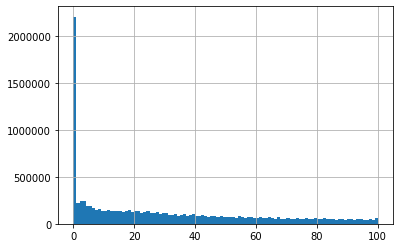

In [16]:
train_df.meter_reading.hist(bins=100, range=[0,100])

In [0]:
import numpy as np

train_df.meter_reading = train_df.meter_reading.apply(np.log1p)


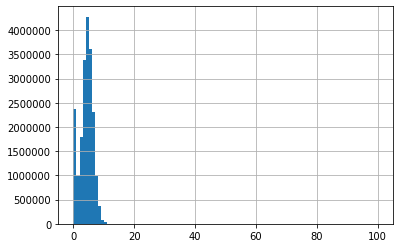

In [18]:
train_df.meter_reading.hist(bins=100, range=[0,100])

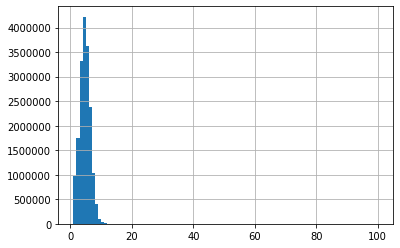

In [19]:
train_df.meter_reading.hist(bins=100, range=[1,100])

# Group by timestamp

In [20]:
train_df.timestamp.unique()

array(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
       '2016-01-01 02:00:00', ..., '2016-12-31 21:00:00',
       '2016-12-31 22:00:00', '2016-12-31 23:00:00'], dtype=object)

In [21]:
train_df.timestamp.value_counts()

2016-12-27 22:00:00    2370
2016-12-27 20:00:00    2369
2016-12-27 21:00:00    2369
2016-12-27 17:00:00    2369
2016-12-27 19:00:00    2369
                       ... 
2016-02-26 01:00:00    1887
2016-02-23 09:00:00    1871
2016-03-23 16:00:00    1822
2016-03-13 03:00:00    1767
2016-03-13 02:00:00    1557
Name: timestamp, Length: 8784, dtype: int64

In [22]:
train_df.timestamp

0           2016-01-01 00:00:00
1           2016-01-01 00:00:00
2           2016-01-01 00:00:00
3           2016-01-01 00:00:00
4           2016-01-01 00:00:00
                   ...         
20216095    2016-12-31 23:00:00
20216096    2016-12-31 23:00:00
20216097    2016-12-31 23:00:00
20216098    2016-12-31 23:00:00
20216099    2016-12-31 23:00:00
Name: timestamp, Length: 20216100, dtype: object

# Filter by meter_id

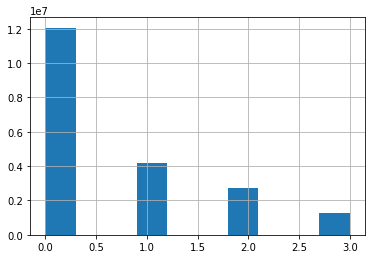

In [23]:
train_df.meter.hist()

In [24]:
train_df.meter.unique()

array([0, 3, 1, 2])

In [25]:
train_df.meter.value_counts()# same as train_df.groupby('meter').size()
# Most of data is of type 0=electricity

0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

In [8]:
meters_types_data = train_df.groupby('meter')
meters_types_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
105,106,3,2016-01-01 00:00:00,0.000000,1,Education,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
109,109,3,2016-01-01 00:00:00,0.000000,1,Education,56995,1953.0,6.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
113,112,3,2016-01-01 00:00:00,4.584743,1,Education,32206,NaN,6.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
115,113,3,2016-01-01 00:00:00,3.025145,1,Education,100481,1958.0,9.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
117,114,3,2016-01-01 00:00:00,4.615121,1,Education,139683,1958.0,13.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1


In [27]:
meters_types_data.count()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
meter,,,,,,,,,,,,,,,
0,12060910,12060910,12060910,12060910,12060910,12060910,5590875,2964827,12013585,6731258,12011819,9547231,11042527,11382195,11994115
1,4182440,4182440,4182440,4182440,4182440,4182440,1362881,209891,4158938,2440144,4158099,3640875,4077393,3779896,4145110
2,2708713,2708713,2708713,2708713,2708713,2708713,567697,104597,2685881,1461042,2685226,2202497,2614929,2398650,2674539
3,1264037,1264037,1264037,1264037,1264037,1264037,567002,227618,1261038,758291,1260816,1076474,1249582,1206311,1258660


In [28]:
meters_types_data.size()

meter
0    12060910
1     4182440
2     2708713
3     1264037
dtype: int64

In [29]:
meters_types_data.mean()

,building_id,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
meter,,,,,,,,,,,,,
0,706.647989,3.977567,6.749956,92714.311950,1968.334837,3.798080,16.009653,2.284164,8.334990,0.801528,1016.407898,176.359898,3.559324
1,887.157200,4.246052,9.273534,126915.411699,1969.564241,6.342697,16.766496,1.422822,7.097000,0.760519,1015.464026,165.579998,3.078658
2,1105.916492,5.123080,11.634820,141968.440365,1961.850078,9.030584,14.137690,1.300219,7.588065,0.967891,1016.480608,167.362113,3.143017
3,735.242757,3.324528,7.800220,115000.353802,1971.043638,5.006129,17.154435,1.187342,4.634209,0.521646,1014.437338,175.993088,3.127668


In [30]:
meters_types_data.mean().meter_reading

meter
0    3.977567
1    4.246052
2    5.123080
3    3.324528
Name: meter_reading, dtype: float64

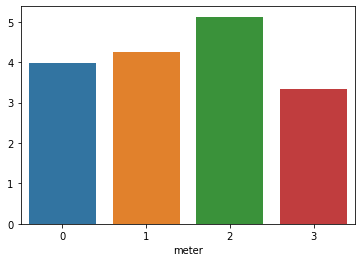

In [31]:
import seaborn as sns
sns.barplot(x=meters_types_data.mean().meter_reading.index, y=meters_types_data.mean().meter_reading.values)

We need to check if the dist of meter readings per type is skewed, or we can use the mean safely?

Hist of meter readings per metertype (expected to be uniform as described above)

In [32]:
for name, group in meters_types_data:
  print(name)
  print(group)

0
          building_id  meter  ... wind_direction  wind_speed
0                   0      0  ...            0.0         0.0
1                   1      0  ...            0.0         0.0
2                   2      0  ...            0.0         0.0
3                   3      0  ...            0.0         0.0
4                   4      0  ...            0.0         0.0
...               ...    ...  ...            ...         ...
20216095         1444      0  ...          180.0         8.8
20216096         1445      0  ...          180.0         8.8
20216097         1446      0  ...          180.0         8.8
20216098         1447      0  ...          180.0         8.8
20216099         1448      0  ...          180.0         8.8

[12060910 rows x 16 columns]
1
          building_id  meter  ... wind_direction  wind_speed
172               161      1  ...          270.0         3.6
174               162      1  ...          270.0         3.6
176               163      1  ...          270.0   

In [9]:
meters_types_data_dict = dict(list(meters_types_data))
meters_types_data_dict

{0:           building_id  meter  ... wind_direction  wind_speed
 0                   0      0  ...            0.0         0.0
 1                   1      0  ...            0.0         0.0
 2                   2      0  ...            0.0         0.0
 3                   3      0  ...            0.0         0.0
 4                   4      0  ...            0.0         0.0
 ...               ...    ...  ...            ...         ...
 20216095         1444      0  ...          180.0         8.8
 20216096         1445      0  ...          180.0         8.8
 20216097         1446      0  ...          180.0         8.8
 20216098         1447      0  ...          180.0         8.8
 20216099         1448      0  ...          180.0         8.8
 
 [12060910 rows x 16 columns],
 1:           building_id  meter  ... wind_direction  wind_speed
 172               161      1  ...          270.0         3.6
 174               162      1  ...          270.0         3.6
 176               163      1  

In [0]:
meters_types_data_dict[0]

Now we hist the meter_reading per type
We know the means per type from above:
```
meters_types_data.mean().meter_reading

meter
0      170.825636
1      633.363924
2    13882.187689
3      385.866781
Name: meter_reading, dtype: float64
```

Remember to drop the 0 values, so the range shall start from 1 (or more)?

In [0]:
print(meters_types_data_dict[0].meter_reading.mean())
meters_types_data_dict[0].meter_reading.hist(bins=100, range=[0,40])

In [0]:
print(meters_types_data_dict[1].meter_reading.mean())
meters_types_data_dict[1].meter_reading.hist(bins=100, range=[0,40])

In [0]:
print(meters_types_data_dict[2].meter_reading.mean())
meters_types_data_dict[2].meter_reading.hist(bins=100, range=[0,40])

In [0]:
print(meters_types_data_dict[3].meter_reading.mean())
meters_types_data_dict[3].meter_reading.hist(bins=100, range=[0,40])

So with log1p, we don't have skew anymore. However, we have a lot of 0 values. The means are slightly different among meter_id's 

# Distribution per meter id among time stamps

In [0]:
meters_types_data_dict[0]

In [0]:
meters_types_data_dict[0].groupby('timestamp').mean()

In [0]:
meters_types_data_dict[0].groupby('timestamp').mean().meter_reading

In [0]:
meters_types_data_dict[0].groupby('timestamp').mean().meter_reading.mean()

In [0]:
meters_types_data_dict[0].groupby('timestamp').mean().meter_reading.hist(bins=100, range=[0,10])

In [0]:
#sns.barplot(x=meters_types_data_dict[0].groupby('timestamp').mean().index, y=meters_types_data_dict[0].groupby('timestamp').mean().meter_reading)

In [0]:
#time_dist_0 = dict(list(meters_types_data_dict[0].groupby('timestamp')))
#time_dist_0

In [0]:
meters_types_data_dict[1].groupby('timestamp').mean().meter_reading.mean()

In [0]:
meters_types_data_dict[1].groupby('timestamp').mean().meter_reading.hist(bins=100, range=[0,10])

In [0]:
meters_types_data_dict[2].groupby('timestamp').mean().meter_reading.mean()

In [0]:
meters_types_data_dict[2].groupby('timestamp').mean().meter_reading.hist(bins=100, range=[0,10])

In [0]:
meters_types_data_dict[3].groupby('timestamp').mean().meter_reading.mean()

In [0]:
meters_types_data_dict[3].groupby('timestamp').mean().meter_reading.hist(bins=100, range=[0,10])

When we get the mean per timestamp interval (1hour), we kind of remove the 0 readings. We still get skewed distributions for groups 1,2 and 3, while 0 (elec) is normal.

In [0]:
avg_reading_per_hour_0 = meters_types_data_dict[0].groupby('timestamp').mean().meter_reading

In [0]:
avg_reading_per_hour_0.plot() # Hourly

In [0]:
avg_reading_per_hour_0.rolling(24).mean().plot() # Daily

In [0]:
avg_reading_per_hour_0.rolling(24*30).mean().plot() # Monthly

In [0]:
avg_reading_per_hour_0.rolling(24*30*3).mean().plot()

In [0]:
#avg_reading_per_hour_0.resample('Q-JAN')

In [0]:
# Electricity pattern
avg_reading_per_hour = meters_types_data_dict[0].groupby('timestamp').mean().meter_reading
avg_reading_per_hour.plot() # Hourly
avg_reading_per_hour.rolling(24).mean().plot() # Daily
avg_reading_per_hour.rolling(24*30).mean().plot() # Monthly
avg_reading_per_hour.rolling(24*30*3).mean().plot() # Quartely

In [0]:
# chilledwater pattern
avg_reading_per_hour = meters_types_data_dict[1].groupby('timestamp').mean().meter_reading
avg_reading_per_hour.plot() # Hourly
avg_reading_per_hour.rolling(24).mean().plot() # Daily
avg_reading_per_hour.rolling(24*30).mean().plot() # Monthly
avg_reading_per_hour.rolling(24*30*3).mean().plot() # Quartely

In [0]:
# steam pattern
avg_reading_per_hour = meters_types_data_dict[2].groupby('timestamp').mean().meter_reading
avg_reading_per_hour.plot() # Hourly
avg_reading_per_hour.rolling(24).mean().plot() # Daily
avg_reading_per_hour.rolling(24*30).mean().plot() # Monthly
avg_reading_per_hour.rolling(24*30*3).mean().plot() # Quartely

In [0]:
# hotwater pattern
avg_reading_per_hour = meters_types_data_dict[3].groupby('timestamp').mean().meter_reading
avg_reading_per_hour.plot() # Hourly
avg_reading_per_hour.rolling(24).mean().plot() # Daily
avg_reading_per_hour.rolling(24*30).mean().plot() # Monthly
avg_reading_per_hour.rolling(24*30*3).mean().plot() # Quartely

As expected, the pattern increases mostly around the end of the year (Autumn and Winter), and the start of the year. The exception is the steam pattern. The daily patterns peaks around the weakend.

In [0]:
import seaborn as sns
#plt.matshow(train_df.corr())
corr = train_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [0]:

corr = meters_types_data_dict[0].groupby('timestamp').mean().corr() 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

See how the meter column is insignificant now, since we already filter on it.

Now the meter reading has high correlation with dew and air temp. Which is clear also in the season dist. above.

In [0]:
corr = meters_types_data_dict[1].groupby('timestamp').mean().corr() 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [0]:
corr = meters_types_data_dict[2].groupby('timestamp').mean().corr() 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [0]:
corr = meters_types_data_dict[3].groupby('timestamp').mean().corr() 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

When we filter by the meter_id and average across timestamps, we find negative correlation for steam and hotwater with the temprature. This is also reflected in the plots above. Most probably this is because when temp goes down, hotwater and steam consumption increases.

the weakend (probably holidays also) pattern (peaks), appears only in electricity type.

# Filter by building_id

In [0]:
#meters_types_data_dict[0].groupby('building_id')

In [10]:
meter_types_per_building = train_df.groupby(['meter','building_id'])
meter_types_per_building.mean()

meter_reading  site_id  ...  wind_direction  wind_speed
meter building_id                          ...                            
0     0                 3.356302        0  ...      156.494024    3.375114
      1                 2.990028        0  ...      156.494024    3.375114
      2                 1.851904        0  ...      156.494024    3.375114
      3                 3.626757        0  ...      156.494024    3.375114
      4                 4.546479        0  ...      156.494024    3.375114
...                          ...      ...  ...             ...         ...
3     1322              6.356525       14  ...      187.723813    3.076776
      1323              7.059714       14  ...      187.748026    3.076474
      1324              2.514697       14  ...      187.723813    3.076776
      1325              5.475693       15  ...      182.766049    3.507951
      1331              8.171454       15  ...      184.415717    3.553795

[2380 rows x 12 columns]

In [0]:
meter_types_per_building_dict = dict(list(meter_types_per_building))

In [0]:
train_df.building_id.unique()

In [0]:
train_df.building_id.hist(bins=len(train_df.building_id.unique()))# Not every building has one meter

In [0]:
building_data = train_df.groupby('building_id')
building_data.head()

In [0]:
building_data.loc(building_id='0')

In [0]:
building_data.count()

# Tables joining --> train_df

## Ensure no missing keys:
- train: timestamp, building_id --> building_meta: building_id | site_id --> weather(site_id, timestamp). Checks:

1. train(timestamps) <> weather(timestamps)
2. train(building_id) <> building_meta(building_id)
3. building(train(building_id) | site_id) <> weather(site_id)

# EDA:

# Hist

# Skew?

# Target var: skew?
- Log1p + 1

# Correlation to target var



# Types: Categorical | Numerical | Ordinal | Nominal

# Missing vals
# Missing vals handling

# Outliers 

# Data prep:
## Types encoding


# Modeling
# Derived featues:
- Season: Winter|Autumn|Summer|Spring
- Weakend: Y|N
- Holiday: Y|N
- Time-of-day: day|night --> Morning|Afternoon|Evening|Night
## Featues: Xgboost:
1. Individula
2. Additive
3. Ablation

## Model:
Regression:

- xgboost
- DT
- Adaboost
- Lgbm
